In [202]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [203]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [204]:
case = "case14"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

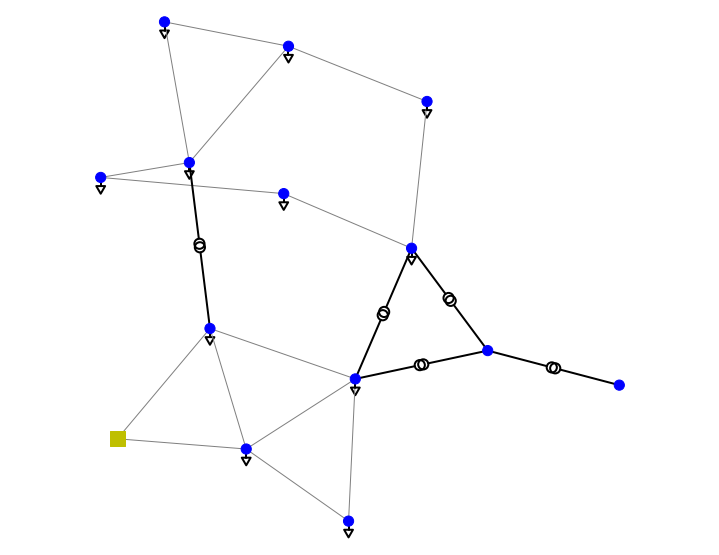

<AxesSubplot:>

In [205]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [206]:
n = len(net.bus)

In [207]:
# net.bus["max_vm_pu"] = np.ones((n,1))*1.05
# net.bus["min_vm_pu"] = np.ones((n,1))*0.99

#### Generators

In [208]:
gen_df_list = []
gen_name_list = ["ext_grid", "gen", "sgen"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [209]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,332.4,0.0,10.0,0.0,ext_grid,0.0,20.0,0.043029,0.0,0.0,0.0
1,0,1,140.0,0.0,50.0,-40.0,gen,0.0,20.0,0.250000,0.0,0.0,0.0
2,1,2,100.0,0.0,40.0,0.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0
3,2,5,100.0,0.0,24.0,-6.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0
4,3,7,100.0,0.0,24.0,-6.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0


#### Bus loads

In [210]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [211]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,21.7,12.7
2,94.2,19.0
3,47.8,-3.9
4,7.6,1.6
5,11.2,7.5
6,0.0,0.0
7,0.0,0.0
8,29.5,16.6
9,9.0,5.8


#### Admittance matrices

In [212]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [213]:
# compute non-diagonal entries of the admittance matrices (opposite of mutual admittance on each line)
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [214]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [215]:
# compute intermediate values that will sum to the diagonal entries of G and B
G_interm = -np.copy(G_val)
B_interm = -np.copy(B_val)
# add line susceptance
for _, row in net.line.iterrows():
    B_interm[row["from_bus"]][row["to_bus"]] += row["s_pu"] / 2
    B_interm[row["to_bus"]][row["from_bus"]] += row["s_pu"] / 2
# transformers
for _, row in net.trafo.iterrows():
    h = row["hv_bus"]
    l = row["lv_bus"]
    ratio_magnitude = (row["vn_hv_kv"] / row["vn_lv_kv"]) * (net.bus.loc[l]["vn_kv"] / net.bus.loc[h]["vn_kv"])
    ratio_sq = ratio_magnitude**2
    G_interm[h][l] /= ratio_sq
    B_interm[h][l] /= ratio_sq
    G_interm[l][h] *= ratio_sq
    B_interm[l][h] *= ratio_sq
    # shift degrees
    # FIXME
    if row["tap_phase_shifter"]:
        theta = row["shift_degree"]
        ratios_denom = np.exp(-1j * (2 * theta / 180 * np.pi))
        G_val[h][l] /= ratios_denom
        B_val[h][l] /= ratios_denom
        G_val[l][h] *= ratios_denom
        B_val[l][h] *= ratios_denom
    
G_row_sums = np.sum(G_interm, axis=1)
B_row_sums = np.sum(B_interm, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        g = shunt_row["p_mw"] / net.sn_mva
        b = -shunt_row["q_mvar"] / net.sn_mva
    G_val[i][i] = g + G_row_sums[i]
    B_val[i][i] = b + B_row_sums[i]

## Variables

In [216]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [217]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [218]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [219]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

## Constraints

### SOCP

In [220]:
constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP

In [221]:
constraints = [X >> 0]

In [222]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [223]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [224]:
# constraints += [ X[0][0] == 1 ]

In [225]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [226]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0))
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0))

In [227]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [228]:
prob.is_dcp()

True

In [229]:
prob.is_dpp()

True

In [248]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)

The optimal value is 8079.95023857195


In [249]:
np.linalg.eigvalsh(X.value)

array([-3.59965054e-09, -3.35635514e-09, -3.25064728e-09, -3.21147676e-09,
       -2.98868540e-09, -2.68076697e-09, -2.23255071e-09, -1.54819841e-09,
       -1.36266131e-09,  5.19930052e-10,  2.07356328e-06,  4.51975410e-06,
        2.48003439e-03,  1.47602421e+01])

In [250]:
np.linalg.eigvalsh(constraints[0].dual_value)

array([-2.45709149e-02,  6.70931569e-04,  1.66387699e+00,  1.30803170e+01,
        2.42783936e+03,  4.88689402e+03,  6.47177467e+03,  8.53905342e+03,
        9.85991901e+03,  1.42205542e+04,  1.95698944e+04,  2.12222245e+04,
        2.52445733e+04,  3.41462161e+04])

In [251]:
np.trace(X.value @ constraints[0].dual_value)

(-0.0002921646723419713-8.495816407827483e-06j)

In [252]:
# recover V by diagonalization
(eigen_val, eigen_vec) = np.linalg.eigh(X.value)
V = np.sqrt(eigen_val[n-1]) * eigen_vec[:,n-1]

# V * np.conj(V.reshape(-1,1))

In [253]:
print(p_g.value)
print(q_g.value)

[[1.94469063e+00]
 [3.67465575e-01]
 [2.89901422e-01]
 [4.42905649e-07]
 [8.05272193e-02]]
[[5.80060487e-07]
 [7.86745877e-02]
 [2.16347297e-01]
 [2.39995737e-01]
 [1.63065519e-01]]


In [254]:
prob.status

'optimal'

In [255]:
# sfm = SolutionFilesManager(folder, case, case_type, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Iterations

In [256]:
# for i in range(n):
#     constraints += [ cp.real(X[i][i]) <= 1.02 * cp.real(X.value[i][i]), cp.real(X[i][i]) >= 0.98 * cp.real(X.value[i][i]) ]

In [257]:
# Y = cp.Parameter((n,n), hermitian=True, value=X.value)
# prod = cp.trace((np.eye(n) * cp.conj(Y)) @ (np.eye(n) * X))
# prob = cp.Problem(cp.Maximize(cp.real(prod)), constraints)

In [258]:
# prob.solve()

In [259]:
# np.linalg.norm(X.value - Y.value)

In [260]:
# np.abs(np.linalg.eigvalsh(X.value))

### Verify constraints with original solution

In [261]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")
_, V_orig, p_orig, q_orig = sfm.load_solution()

In [262]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)
# print(X_orig)

In [263]:
print(p_orig)
print(q_orig)

[[1.94477216e+00]
 [3.67478042e-01]
 [2.90077404e-01]
 [3.65617411e-06]
 [8.02609604e-02]]
[[3.38908804e-06]
 [7.33702082e-02]
 [2.15200860e-01]
 [2.39377128e-01]
 [1.59249086e-01]]


In [264]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([p_orig[k] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_orig[i][i] + np.sum([G_val[i][j] * np.real(X_orig[i][j]) + B_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([q_orig[k] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_orig[i][i] + np.sum([-B_val[i][j] * np.real(X_orig[i][j]) + G_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))

active 0
[1.94477216]
(1.944772224551599+0j)
reactive 0
[3.38908804e-06]
(3.3935171295240707e-06+0j)
active 1
[0.15047804]
(0.15047818755636655+0j)
reactive 1
[-0.05362979]
(-0.05362964429440353+0j)
active 2
[-0.6519226]
(-0.6519225101355453+0j)
reactive 2
[0.02520086]
(0.02520084650656962+0j)
active 3
[-0.478]
(-0.4780000397125814+0j)
reactive 3
[0.039]
(0.03900000763270839+0j)
active 4
[-0.076]
(-0.0759999041582411+0j)
reactive 4
[-0.016]
(-0.015999943035041042+0j)
active 5
[-0.11199634]
(-0.11199711612581975+0j)
reactive 5
[0.16437713]
(0.16437942534470906+0j)
active 6
[0.]
(-9.076545837150007e-08+0j)
reactive 6
[0.]
(7.124612011466525e-11+0j)
active 7
[0.08026096]
(0.08026095339809473+0j)
reactive 7
[0.15924909]
(0.15924989291371716+0j)
active 8
[-0.295]
(-0.29499968005343824+0j)
reactive 8
[-0.166]
(-0.1659999911837886+0j)
active 9
[-0.09]
(-0.08999990488225862+0j)
reactive 9
[-0.058]
(-0.058000007699728684+0j)
active 10
[-0.035]
(-0.034999921534154765+0j)
reactive 10
[-0.018]
(-0